In [1]:
from splat.read_colmap import read_images_text, qvec2rotmat
from splat.gaussians import Gaussians
from splat.gaussian_scene import GaussianScene
import pycolmap
import torch 
import torch.nn as nn
import numpy as np

from splat.utils import read_images_text, read_images_binary

colmap_path = "/Users/derek/Desktop/colmap/360_extra_scenes/treehill/sparse/0"
reconstruction = pycolmap.Reconstruction(colmap_path)
test = False

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []
image_num = 100

for idx, point in enumerate(points3d.values()):
    # I would assume this is seeing it from multiple images
    if point.track.length() >= 2:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color)
        
image = images[image_num]
points_in_3d = []
points2d = []
colors2d = []
for idx, point in enumerate(image.xys):
    point3d_id = image.point3D_ids[idx]
    if point3d_id > 0:
        try:
            color = points3d[point3d_id].color
            points_in_3d.append(points3d[point3d_id].xyz)
            points2d.append(point)
            colors2d.append(color)
        except:
            pass
        
all_points3d = np.array(all_points3d)
all_point_colors = np.array(all_point_colors)
points_in_3d = np.array(points_in_3d)
points2d = np.array(points2d)
colors2d = np.array(colors2d)

print(all_points3d.shape, points_in_3d.shape)
gaussians = Gaussians(
    torch.Tensor(points_in_3d), 
    torch.Tensor(colors2d),
    model_path="./point_clouds"
)

(52363, 3) (1697, 3)
initialized_points


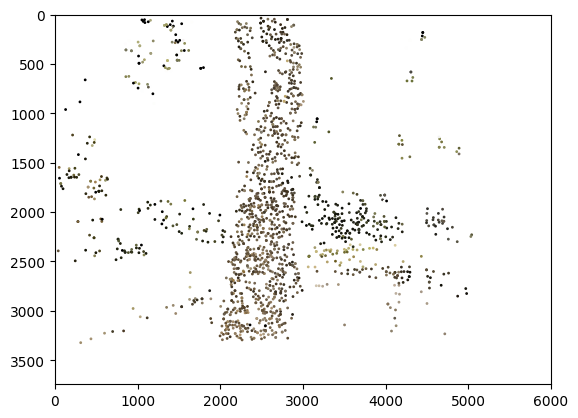

In [2]:
import matplotlib.pyplot as plt

scene = GaussianScene(
    colmap_path=colmap_path,
    gaussians=gaussians,
)

plt.scatter(points2d[:, 0], points2d[:, 1], c=colors2d / 256, s=1)
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis() 

torch.Size([1697, 3])


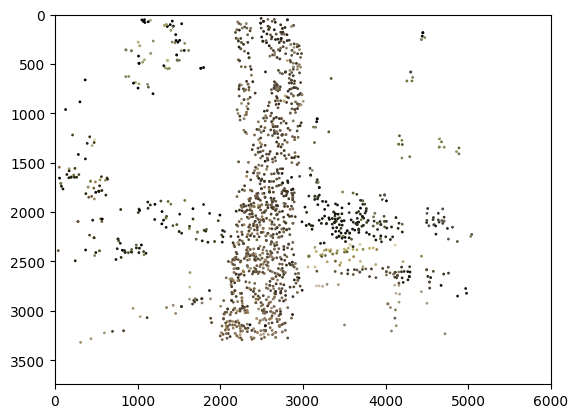

In [3]:
with torch.no_grad():
    points, colors = scene.render_points_image(image_num)

print(points.shape)
plt.scatter(points[:, 0], points[:, 1], c=colors, s=1)
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis() 

torch.Size([1697, 3])


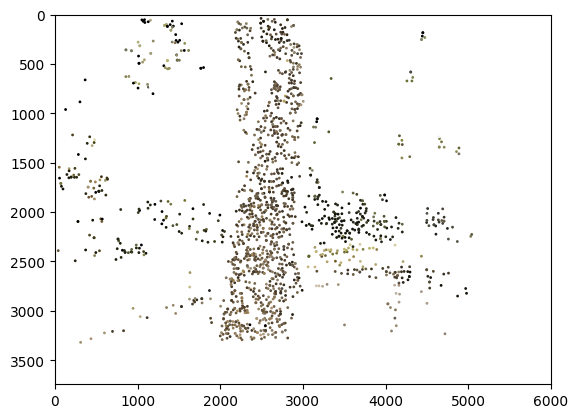

In [4]:
processed_scene = scene.preprocess(image_num)
print(points.shape)
plt.scatter(processed_scene.points_xy[:, 0].detach(), processed_scene.points_xy[:, 1].detach(), c=processed_scene.colors.detach(), s=1)
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis() 

In [5]:
image = scene.render_image(image_num)

> /Users/derek/Desktop/personal_gaussian_splatting/splat/gaussian_scene.py(183)render_pixel()
    181             weight *= torch.sigmoid(opacities[point_idx])
    182             import pdb; pdb.set_trace()
--> 183             if weight + total_weight > max_weight:
    184                 return pixel_color
    185             import pdb; pdb.set_trace()

> /Users/derek/Desktop/personal_gaussian_splatting/splat/gaussian_scene.py(186)render_pixel()
    184                 return pixel_color
    185             import pdb; pdb.set_trace()
--> 186             pixel_color += (1 - total_weight) * weight * colors[point_idx]
    187             total_weight += weight
    188         # in case we never reach saturation

tensor([0.9959, 0.9881, 0.9920], grad_fn=<MulBackward0>)
tensor([0.9961, 0.9883, 0.9922], grad_fn=<SelectBackward0>)
